In [1]:
import numpy as np
from tqdm import tqdm
import copy
import matplotlib.pyplot as plt
from matplotlib import cm
import torch
from torch.optim.lr_scheduler import StepLR
import albumentations as A
from pathSeg.ml.hovernet import HoVerNet, loss_hovernet, post_process_batch_hovernet
from pathSeg.ml.utils import dice_score
from pathSeg.utils import plot_segmentation
import pytorch_model_summary as tms
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as transforms
import scipy.io
from glob import glob
from PIL import Image   
from loguru import logger
from torchvision.transforms import ToTensor
import cv2
import random
from sklearn.model_selection import train_test_split
print(f"GPUs used:\t{torch.cuda.device_count()}")
device = torch.device("cuda:4")
print(f"Device:\t\t{device}")

GPUs used:	8
Device:		cuda:4


In [2]:
params={'image_size':1024,
        'lr':1e-4,
        'beta1':0.5,
        'beta2':0.999,
        'batch_size':1,
        'epochs':1000,
        'n_classes':None,
        'data_path':'../../data/segmentation/qupath/'}

tf = ToTensor()

In [3]:



def compute_hv_map(mask):
    assert (
        mask.ndim == 2
    ), f"Input mask has shape {mask.shape}. Expecting a mask with 2 dimensions (H, W)"

    out = np.zeros((2, mask.shape[0], mask.shape[1]))
    # each individual nucleus is indexed with a different number
    hv_list = list(np.unique(mask))

    try:
        hv_list.remove(0)  # 0 is background
    # TODO: change to specific exception
    except Exception:
        logger.warning(
            "No pixels with 0 label. This means that there are no background pixels. This may indicate a problem. Ignore this warning if this is expected/intended."
        )

    for hv_id in hv_list:
        # get the mask for the nucleus
        hv_map = mask == hv_id
        hv_map = hv_map.astype(np.uint8)
        contours, _ = cv2.findContours(
            hv_map, mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_NONE
        )

        # get center of mass coords
        mom = cv2.moments(contours[0])
        com_x = mom["m10"] / (mom["m00"] + 1e-6)
        com_y = mom["m01"] / (mom["m00"] + 1e-6)
        hv_com = (int(com_y), int(com_x))

        hv_x_range = np.arange(1, hv_map.shape[1] + 1)
        hv_y_range = np.arange(1, hv_map.shape[0] + 1)
        # shifting center of pixels grid to hvance center of mass
        hv_x_range -= hv_com[1]
        hv_y_range -= hv_com[0]

        hv_x, hv_y = np.meshgrid(hv_x_range, hv_y_range)

        # remove coord outside of hvance
        hv_x[hv_map == 0] = 0
        hv_y[hv_map == 0] = 0
        hv_x = hv_x.astype("float32")
        hv_y = hv_y.astype("float32")

        # normalize min into -1 scale
        if np.min(hv_x) < 0:
            hv_x[hv_x < 0] /= -np.amin(hv_x[hv_x < 0])
        if np.min(hv_y) < 0:
            hv_y[hv_y < 0] /= -np.amin(hv_y[hv_y < 0])
        # normalize max into +1 scale
        if np.max(hv_x) > 0:
            hv_x[hv_x > 0] /= np.amax(hv_x[hv_x > 0])
        if np.max(hv_y) > 0:
            hv_y[hv_y > 0] /= np.amax(hv_y[hv_y > 0])
        
        # add to output mask
        # this works assuming background is 0, and each pixel is assigned to only one nucleus.
        out[0, :, :] += hv_x
        out[1, :, :] += hv_y
    return out



class CustomDataset(Dataset):
    """COCO Custom Dataset compatible with torch.utils.data.DataLoader."""
    def __init__(self,parmas, images,masks,mat_list):
        
        self.images = images
        self.masks=masks
        self.mat_list=mat_list
        self.args=parmas
        
    def trans(self,image,mask,hv_mask):
        if random.random() > 0.5:
            transform = transforms.RandomHorizontalFlip(1)
            image = transform(image)
            mask = transform(mask)
            hv_mask = transform(hv_mask)
            
        if random.random() > 0.5:
            transform = transforms.RandomVerticalFlip(1)
            image = transform(image)
            mask = transform(mask)
            hv_mask = transform(hv_mask)
            
        return image,mask,hv_mask
    
    def __getitem__(self, index):
        image=self.images[index]
        mask=self.masks[index]
        hv_mask=self.mat_list[index]
        return image,mask,hv_mask
    
    def __len__(self):
        return len(self.images)

transform1=transforms.RandomHorizontalFlip(1)
transform2=transforms.RandomVerticalFlip(1)
image_list=glob(params['data_path']+'image/*.jpeg')
npy_list=[f.replace('image/', 'mask/') for f in image_list]
npy_list=[f.replace('.jpeg', '.npy') for f in npy_list]
train_image_list,test_image_list,train_mask_list,test_mask_list=train_test_split(image_list,npy_list,test_size=0.1,random_state=30)
train_masks=torch.zeros((len(train_mask_list)*4,2,1024,1024))
train_images=torch.zeros((len(train_image_list)*4,3,1024,1024))
train_hv_mask=torch.zeros((len(train_image_list)*4,2,1024,1024))
for i in tqdm(range(len(train_image_list))):
    npy_file =np.load(train_mask_list[i]).astype(np.int32)
    mask=torch.tensor(npy_file)
    index=i*4
    train_images[index]=tf(Image.open(image_list[i]).convert('RGB'))
    train_images[index+1]=transform1(train_images[index])
    train_images[index+2]=transform2(train_images[index])
    train_images[index+3]=transform1(transform2(train_images[index]))
    
    train_masks[index,0,:,:]=mask>0
    train_masks[index,1,:,:]=mask==0
    train_masks[index+1]=transform1(train_masks[index])
    train_masks[index+2]=transform2(train_masks[index])
    train_masks[index+3]=transform1(transform2(train_masks[index]))
    
    train_hv_mask[index]=torch.tensor(compute_hv_map(npy_file))
    train_hv_mask[index+1]=torch.tensor(compute_hv_map(np.array(transform1(mask))))
    train_hv_mask[index+2]=torch.tensor(compute_hv_map(np.array(transform2(mask))))
    train_hv_mask[index+3]=torch.tensor(compute_hv_map(np.array(transform1(transform2(mask)))))
    
test_masks=torch.zeros((len(test_mask_list)*4,2,1024,1024))
test_images=torch.zeros((len(test_image_list)*4,3,1024,1024))
test_hv_mask=torch.zeros((len(test_image_list)*4,2,1024,1024))
for i in tqdm(range(len(test_image_list))):
    npy_file =np.load(test_mask_list[i]).astype(np.int32)
    mask=torch.tensor(npy_file)
    index=i*4
    test_images[index]=tf(Image.open(image_list[i]).convert('RGB'))
    test_images[index+1]=transform1(test_images[index])
    test_images[index+2]=transform2(test_images[index])
    test_images[index+3]=transform1(transform2(test_images[index]))
    
    test_masks[index,0,:,:]=mask>0
    test_masks[index,1,:,:]=mask==0
    test_masks[index+1]=transform1(test_masks[index])
    test_masks[index+2]=transform2(test_masks[index])
    test_masks[index+3]=transform1(transform2(test_masks[index]))
    
    test_hv_mask[index]=torch.tensor(compute_hv_map(npy_file))
    test_hv_mask[index+1]=torch.tensor(compute_hv_map(np.array(transform1(mask))))
    test_hv_mask[index+2]=torch.tensor(compute_hv_map(np.array(transform2(mask))))
    test_hv_mask[index+3]=torch.tensor(compute_hv_map(np.array(transform1(transform2(mask)))))
    
train_dataset=CustomDataset(params,train_images,train_masks,train_hv_mask)
test_dataset=CustomDataset(params,test_images,test_masks,test_hv_mask)
train_dataloader=DataLoader(train_dataset,batch_size=params['batch_size'],shuffle=True)
val_dataloader=DataLoader(test_dataset,batch_size=params['batch_size'],shuffle=True)

100%|██████████| 7/7 [10:31<00:00, 90.19s/it] 


In [4]:
# load the model
hovernet = HoVerNet(n_classes=params['n_classes']).to(device)

opt = torch.optim.Adam(hovernet.parameters(), lr = params['lr'], betas=(params['beta1'], params['beta2']))
# learning rate scheduler to reduce LR by factor of 10 each 25 epochs
scheduler = StepLR(opt, step_size=25, gamma=0.1)
tms.summary(hovernet, torch.zeros(params['batch_size'],3, params['image_size'], params['image_size']).to(device),print_summary=True)

---------------------------------------------------------------------------------------------------------------------------------------------
         Layer (type)                                                                           Output Shape         Param #     Tr. Param #
   _HoVerNetEncoder-1     [1, 256, 1024, 1024], [1, 512, 512, 512], [1, 1024, 256, 256], [1, 1024, 128, 128]      25,590,912      25,590,912
   _HoverNetDecoder-2                                                                    [1, 64, 1024, 1024]      10,638,848      10,638,848
             Conv2d-3                                                                     [1, 2, 1024, 1024]             130             130
   _HoverNetDecoder-4                                                                    [1, 64, 1024, 1024]      10,638,848      10,638,848
             Conv2d-5                                                                     [1, 2, 1024, 1024]             130             130
Total params

'---------------------------------------------------------------------------------------------------------------------------------------------\n         Layer (type)                                                                           Output Shape         Param #     Tr. Param #\n=============================================================================================================================================\n   _HoVerNetEncoder-1     [1, 256, 1024, 1024], [1, 512, 512, 512], [1, 1024, 256, 256], [1, 1024, 128, 128]      25,590,912      25,590,912\n   _HoverNetDecoder-2                                                                    [1, 64, 1024, 1024]      10,638,848      10,638,848\n             Conv2d-3                                                                     [1, 2, 1024, 1024]             130             130\n   _HoverNetDecoder-4                                                                    [1, 64, 1024, 1024]      10,638,848      10,638,848\n   

/tmp/ipykernel_586971/1605181402.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm_mask = copy.copy(cm.get_cmap("tab10"))


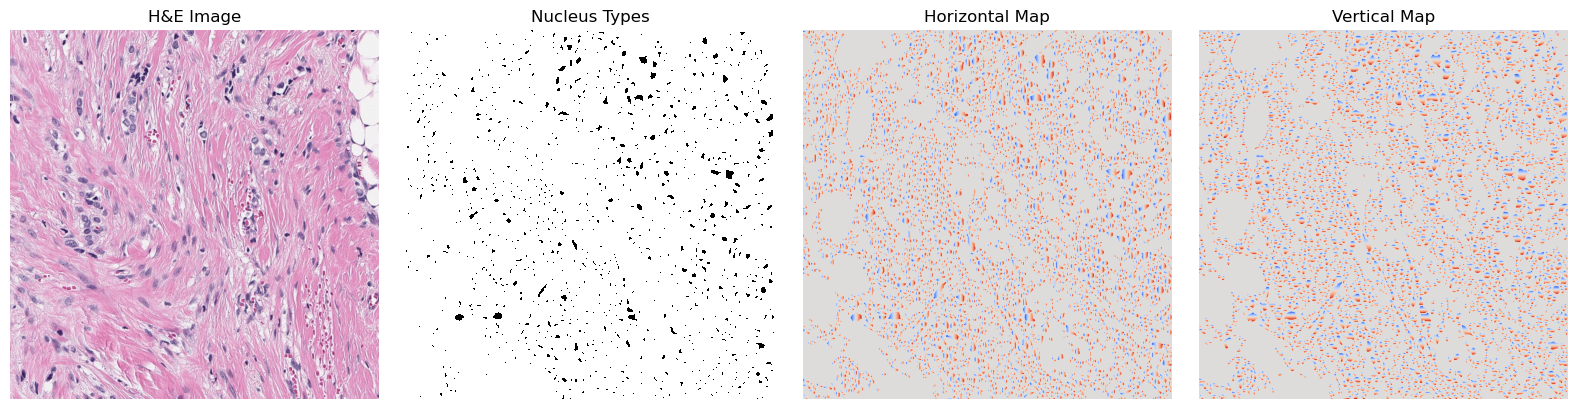

In [5]:
images, masks, hvs = next(iter(train_dataloader))

n = params['batch_size']
fig, ax = plt.subplots(nrows=1, ncols=4, figsize = (16, 4))

cm_mask = copy.copy(cm.get_cmap("tab10"))
cm_mask.set_bad(color='white')

for i in range(n):
    im = images[i, ...].numpy()
    ax[ 0].imshow(np.moveaxis(im, 0, 2))
    m = masks.argmax(dim=1)[i, ...]
    m = np.ma.masked_where(m == 1, m)
    ax[ 1].imshow(m,cmap='gray')
    ax[ 2].imshow(hvs[i, 0, ...], cmap = 'coolwarm')
    ax[ 3].imshow(hvs[i, 1, ...], cmap = 'coolwarm')
    
for a in ax.ravel(): a.axis("off")
for c,v in enumerate(["H&E Image", "Nucleus Types", "Horizontal Map", "Vertical Map"]):
    ax[c].set_title(v)
    
plt.tight_layout()
plt.show()


In [6]:
n_epochs = params['epochs']
# print performance metrics every n epochs

# evaluating performance on a random subset of validation mini-batches
# this saves time instead of evaluating on the entire validation set
n_minibatch_valid = 10

epoch_train_losses = {}
epoch_valid_losses = {}
epoch_train_dice = {}
epoch_valid_dice = {}

best_epoch = 0
# main training loop
for i in range(n_epochs):
    minibatch_train_losses = []
    minibatch_train_dice = []
    
    # put model in training mode
    hovernet.train()
    train_tqdm=tqdm(train_dataloader)
    for data in train_tqdm:
        # send the data to the GPU
        images = data[0].float().to(device)
        masks = data[1].to(device)
        hv = data[2].float().to(device)
        
        # zero out gradient
        opt.zero_grad()
        
        # forward pass
        outputs = hovernet(images)
        
        # compute loss
        loss = loss_hovernet(outputs = outputs, ground_truth = [masks, hv], n_classes=params['n_classes']).to(device)
        
        # track loss
        minibatch_train_losses.append(loss.item())
        
        # also track dice score to measure performance
        preds_detection = post_process_batch_hovernet(outputs, n_classes=params['n_classes'])
        truth_binary = masks[:, 0, :, :] == 1
        dice = dice_score(preds_detection, truth_binary.cpu().numpy())
        minibatch_train_dice.append(dice)
        
        # compute gradients
        loss.backward()
        
        # step optimizer and scheduler
        opt.step()
        train_tqdm.set_description(f"train epoch: {i+1}/{n_epochs} loss : {np.mean(minibatch_train_losses):.4f} dice: {np.mean(minibatch_train_dice):.4f}")
    #step LR scheduler
    scheduler.step()
    
    # evaluate on random subset of validation data
    hovernet.eval()
    minibatch_valid_losses = []
    minibatch_valid_dice = []
    # randomly choose minibatches for evaluating
    minibatch_ix = np.random.choice(range(len(val_dataloader)), replace=True, size=n_minibatch_valid)
    with torch.no_grad():
        val_tqdm=tqdm(val_dataloader)
        for data in val_tqdm:
            # send the data to the GPU
            images = data[0].float().to(device)
            masks = data[1].to(device)
            hv = data[2].float().to(device)


            # forward pass
            outputs = hovernet(images)

            # compute loss
            loss = loss_hovernet(outputs = outputs, ground_truth = [masks, hv], n_classes=params['n_classes']).to(device)

            # track loss
            minibatch_valid_losses.append(loss.item())

            # also track dice score to measure performance
            preds_detection= post_process_batch_hovernet(outputs, n_classes=params['n_classes'])
            truth_binary = masks[:, 0, :, :] == 1
            dice = dice_score(preds_detection, truth_binary.cpu().numpy())
            minibatch_valid_dice.append(dice)
            val_tqdm.set_description(f"validation epoch: {i+1}/{n_epochs} loss : {np.mean(minibatch_valid_losses):.4f} dice: {np.mean(minibatch_valid_dice):.4f}")
    # average performance metrics over minibatches
    mean_train_loss = np.mean(minibatch_train_losses)
    mean_valid_loss = np.mean(minibatch_valid_losses)
    mean_train_dice = np.mean(minibatch_train_dice)
    mean_valid_dice = np.mean(minibatch_valid_dice)
    
    # save the model with best performance
    if i != 0:
        if mean_valid_loss < min(epoch_valid_losses.values()):
            best_epoch = i
            torch.save(hovernet.state_dict(), f"../../model/pathSeg/hovernet_binary_qupath_best_perf.pt")
    
    # track performance over training epochs
    epoch_train_losses.update({i : mean_train_loss})
    epoch_valid_losses.update({i : mean_valid_loss})
    epoch_train_dice.update({i : mean_train_dice})
    epoch_valid_dice.update({i : mean_valid_dice})
    
    # print(f"Epoch {i+1}/{n_epochs} training loss: {np.round(mean_train_loss, 4)} validation loss: {np.round(mean_valid_loss, 4)} training dice: {np.round(mean_train_dice, 4)} validation dice: {np.round(mean_valid_dice, 4)}")
# save fully trained model
torch.save(hovernet.state_dict(), f"../../model/pathSeg/hovernet_binary_qupath_fully_trained.pt")
print(f"\nEpoch with best validation performance: {best_epoch}")

  0%|          | 0/232 [00:00<?, ?it/s]

/home/gil/anaconda3/envs/LeeYS/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
train epoch: 1/1000 loss : 11.9386 dice: 0.0016: 100%|██████████| 232/232 [05:27<00:00,  1.41s/it]
validation epoch: 1/1000 loss : 11.2681 dice: 0.0000: 100%|██████████| 28/28 [00:12<00:00,  2.20it/s]
train epoch: 2/1000 loss : 11.7706 dice: 0.0000: 100%|██████████| 232/232 [04:52<00:00,  1.26s/it]
validation epoch: 2/1000 loss : 11.2343 dice: 0.0000: 100%|██████████| 28/28 [00:12<00:00,  2.19it/s]
train epoch: 3/1000 loss : 11.6509 dice: 0.0000:  28%|██▊       | 64/232 [01:21<03:33,  1.27s/it]


KeyboardInterrupt: 

: 

In [ ]:
fix, ax = plt.subplots(nrows=1, ncols=2, figsize = (10, 4))

ax[0].plot(epoch_train_losses.keys(), epoch_train_losses.values(), label = "Train")
ax[0].plot(epoch_valid_losses.keys(), epoch_valid_losses.values(), label = "Validation")
ax[0].scatter(x=best_epoch, y=epoch_valid_losses[best_epoch], label = "Best Model",
              color = "green", marker="*")
ax[0].set_title("Training: Loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()

ax[1].plot(epoch_train_dice.keys(), epoch_train_dice.values(), label = "Train")
ax[1].plot(epoch_valid_dice.keys(), epoch_valid_dice.values(), label = "Validation")
ax[1].scatter(x=best_epoch, y=epoch_valid_dice[best_epoch], label = "Best Model",
              color = "green", marker="*")
ax[1].set_title("Training: Dice Score")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Dice Score")
ax[1].legend()
plt.show()

In [ ]:
checkpoint = torch.load("../../model/pathSeg/hovernet_binary_best_perf.pt")
hovernet.load_state_dict(checkpoint)

In [ ]:
hovernet.eval()

ims = None
mask_truth = None
mask_pred = None
tissue_types = []

with torch.no_grad():
    for i, data in tqdm(enumerate(val_dataloader)):
        # send the data to the GPU
        images = data[0].float().to(device)
        masks = data[1].to(device)
        hv = data[2].float().to(device)
        truth_binary = masks[:, 0, :, :] == 1

        # pass thru network to get predictions
        outputs = hovernet(images)
        preds_detection = post_process_batch_hovernet(outputs, n_classes=params['n_classes'])
        
        if i == 0:
            ims = data[0].numpy()
            mask_truth = data[1].numpy()
            mask_pred = preds_detection

        else:
            ims = np.concatenate([ims, data[0].numpy()], axis=0)
            mask_truth = np.concatenate([mask_truth, data[1].numpy()], axis=0)
            mask_pred = np.concatenate([mask_pred, preds_detection], axis=0)

In [ ]:
ims = np.moveaxis(ims, 1, 3)
n = 8
mask_truth=mask_truth[:,0,:,:]==1
mask_truth=mask_truth[:,np.newaxis,:,:] 
mask_pred=mask_pred[:,np.newaxis,:,:] 
ix = np.random.choice(np.arange(7), size = n)
fig, ax = plt.subplots(nrows = n, ncols = 3, figsize = (8, 2.5*n))
for i, index in enumerate(ix):
    ax[i, 0].imshow(ims[index, ...])
    ax[i, 1].imshow(ims[index, ...])
    ax[i, 2].imshow(ims[index, ...])
    plot_segmentation(ax = ax[i, 1], masks = mask_pred[index, ...])
    plot_segmentation(ax = ax[i, 2], masks = mask_truth[index, ...])
        
for a in ax.ravel(): 
    a.get_xaxis().set_ticks([])
    a.get_yaxis().set_ticks([])
ax[0, 0].set_title("image")
ax[0, 1].set_title("Prediction")
ax[0, 2].set_title("Truth")
plt.tight_layout()
plt.show()

In [ ]:
mask_pred